# A. Data Exploration

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## 1. Sentinel 1 radar data and Sentinel 2 multispectral data

Source: Copernicus Browser or in Google Earth Engine

## 2. Specific Marker Wadden data

Source: [Rijkswaterstaat](https://open.rijkswaterstaat.nl/@254169/datarapportage-kima-overzicht-meetdata/)

## 3a. Airborne LiDAR data from AHN

Source: [Actueel Hoogtebestand Nederland (Current Elevation File Netherlands)](https://www.ahn.nl/dataroom)

[GeoTiles TU Delft](https://geotiles.citg.tudelft.nl/)

![Screenshot of data source](images/Screenshot%202025-09-11%20191855.jpg)

In [ ]:
import laspy

laz_files = [
    "data/AHN6/2023_C_20BZ1.LAZ",
    "data/AHN6/2023_C_20BZ2.LAZ",
    "data/AHN6/2023_C_20DN1.LAZ",
    "data/AHN6/2023_C_20DN2.LAZ"
]

# Read one LAZ file at a time and extract a sampled subset of x, y, z coordinates
laz_file_path = laz_files[3]  # Use the 4th file as an example

# Use an existing num_points if defined elsewhere in the notebook, otherwise default to 100k
num_to_sample = globals().get("num_points", 100_000)

with laspy.open(laz_file_path) as f:
    total_points = int(f.header.point_count)
    print(f"Total points in file: {total_points}")

    # Ensure we don't try to sample more than exist
    num_to_sample = min(num_to_sample, total_points)

    # Choose random indices to sample (sorted to speed chunk selection)
    sample_idx = np.random.choice(total_points, size=num_to_sample, replace=False)
    sample_idx.sort()

    # Iterate the file in chunks and pick only the sampled indices to avoid loading the whole file
    xs_chunks = []
    ys_chunks = []
    zs_chunks = []

    offset = 0
    chunk_size = 1_000_000  # adjust if needed based on memory
    collected = 0

    for chunk in f.chunk_iterator(chunk_size):
        chunk_len = len(chunk.x)
        if chunk_len == 0:
            offset += chunk_len
            continue

        # find which sample indices fall within this chunk
        mask = (sample_idx >= offset) & (sample_idx < offset + chunk_len)
        if mask.any():
            local_idx = sample_idx[mask] - offset
            xs_chunks.append(chunk.x[local_idx])
            ys_chunks.append(chunk.y[local_idx])
            zs_chunks.append(chunk.z[local_idx])
            collected += local_idx.size

            if collected >= num_to_sample:
                break

        offset += chunk_len

    if collected == 0:
        raise RuntimeError("No sample points were collected; check file and sampling logic.")

    # Concatenate sampled arrays
    x = np.concatenate(xs_chunks)
    y = np.concatenate(ys_chunks)
    z = np.concatenate(zs_chunks)

    # Create a lightweight placeholder for `laz` so code that reads len(laz) still works
    class _LazyCount:
        def __init__(self, count):
            self._count = int(count)
        def __len__(self):
            return self._count

    laz = _LazyCount(total_points)

print(f"Sampled {len(x)} points from {laz_file_path} (total in file: {len(laz)})")


Total points in file: 95259930
Sampled 100000 points from data/AHN6/2023_C_20DN2.LAZ (total in file: 95259930)


In [14]:
# Print some basic information
# use the loaded coordinate arrays (x, y, z) instead of undefined `point_cloud`
print(f"Number of points: {len(laz)}")
print(f"X range: {x.min()} to {x.max()}")
print(f"Y range: {y.min()} to {y.max()}")
print(f"Z range: {z.min()} to {z.max()}")

Number of points: 95259930
X range: 155000.01 to 159999.991
Y range: 506250.003 to 512499.951
Z range: -5.531 to 24.88


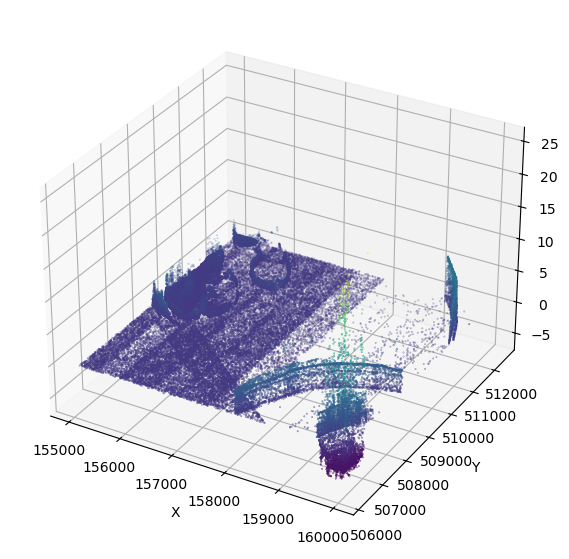

In [ ]:
# Sample a subset of points for visualization to prevent MemoryError
num_points = 100000
indices = np.random.choice(len(x), size=num_points, replace=False)

x_sample = x[indices]
y_sample = y[indices]
z_sample = z[indices]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_sample, y_sample, z_sample, c=z_sample, cmap='viridis', s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [13]:
'''
!pip install jupyterlab "ipywidgets>=7.5"
!jupyter labextension install jupyterlab-plotly
'''

'\n!pip install jupyterlab "ipywidgets>=7.5"\n!jupyter labextension install jupyterlab-plotly\n'

In [ ]:
import plotly.graph_objects as go

# Sample a subset of points for visualization
num_points = 100_000
indices = np.random.choice(len(x), size=num_points, replace=False)
x_sample = x[indices]
y_sample = y[indices]
z_sample = z[indices]

fig = go.Figure(data=[go.Scatter3d(
    x=x_sample, y=y_sample, z=z_sample,
    mode='markers',
    marker=dict(
        size=1,
        color=z_sample,    # set color to the z values
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=900,
    height=700,
    margin=dict(r=10, l=10, b=10, t=10)
)

fig.show()

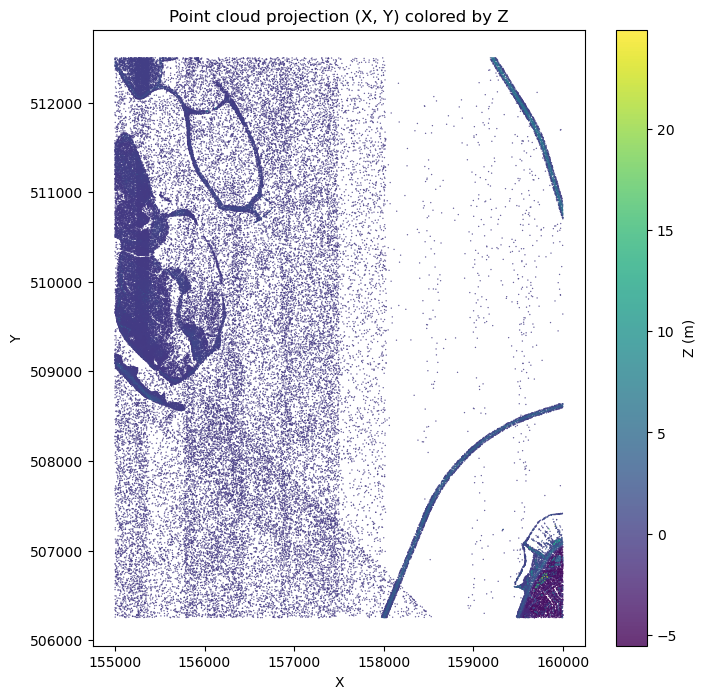

In [ ]:
# 2D scatter of point cloud (X, Y) with Z shown as color
# Uses existing sampled arrays: x_sample, y_sample, z_sample

fig2, ax2 = plt.subplots(figsize=(10, 8))
sc = ax2.scatter(x_sample, y_sample, c=z_sample, s=1, cmap='viridis', alpha=0.8, linewidths=0)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Point cloud projection (X, Y) colored by Z')
ax2.set_aspect('equal', adjustable='box')
cbar = fig2.colorbar(sc, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Z (m)')
plt.show()

## 3b. Aerial photos from BN


Source: [Beeldmateriaal Nederland (Image material Netherlands)](https://www.beeldmateriaal.nl/)

[GeoTiles TU Delft](https://geotiles.citg.tudelft.nl/), 

![GeoJSON data preview showing polygon footprints and metadata for aerial imagery tiles](images/Screenshot%202025-09-13%20091626.jpg)

In [3]:
import geopandas as gpd

# Replace with your GeoJSON file path
geojson_path = "data/BN Imagerial Data/selectie_b2308cf8-260e-4c03-9402-2988cde1071e.geojson"

# Read the GeoJSON file
gdf = gpd.read_file(geojson_path)

# Display the first few rows
print(gdf.head())

                                                file      size  \
0  https://fsn1.your-objectstorage.com/hwh-ortho/...  31329543   
1  https://fsn1.your-objectstorage.com/hwh-ortho/...       592   
2  https://fsn1.your-objectstorage.com/hwh-ortho/...       592   
3  https://fsn1.your-objectstorage.com/hwh-ortho/...  31391908   
4  https://fsn1.your-objectstorage.com/hwh-ortho/...  37684912   

                             mtime  \
0 2025-07-16 08:03:05.442000+00:00   
1 2025-07-16 08:04:56.202000+00:00   
2 2025-07-16 08:02:57.676000+00:00   
3 2025-07-16 08:05:08.142000+00:00   
4 2025-07-16 08:03:59.216000+00:00   

                                              sha256  \
0  34baf6fc00186d7a52e4a3a639e9443127aa7740cbb8b2...   
1  a915577c6150da244ab9c1714bf3f50f1d2f852a3631d1...   
2  a915577c6150da244ab9c1714bf3f50f1d2f852a3631d1...   
3  55ad73aa1cb3fe7ebc661de8bb5c53887b232c77ea4143...   
4  86009ed85ead9c11fb28ab4d7a7f09a303f79f610b54f8...   

                                     

GeoDataFrame has 76 features. CRS: EPSG:28992


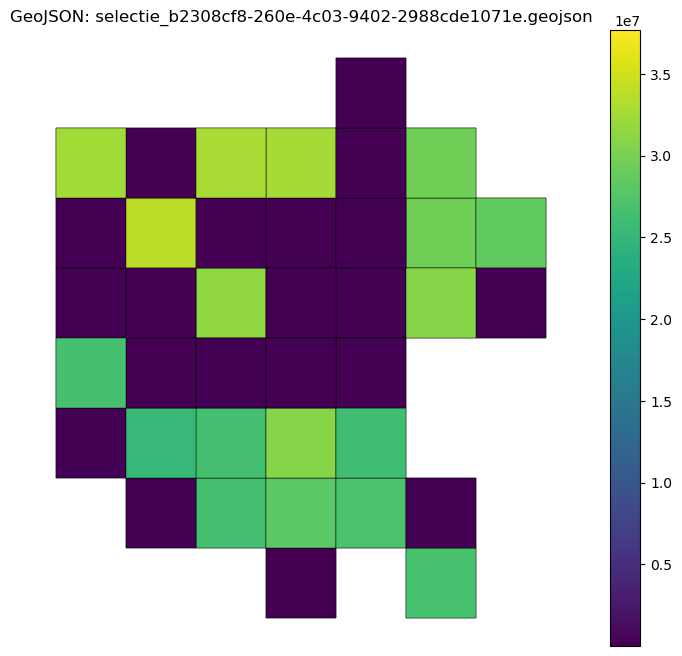

In [4]:
# Use existing `gdf` and `geojson_path`
print(f"GeoDataFrame has {len(gdf)} features. CRS: {gdf.crs}")

# If CRS is missing, assume Dutch RD (EPSG:28992) which matches numeric coords like 153000 511000
if gdf.crs is None:
    try:
        gdf = gdf.set_crs(epsg=28992)
        print("Set CRS to EPSG:28992 (assumed RD New).")
    except Exception as e:
        print("Could not set CRS:", e)

# Choose a column to color by, fallback to plotting geometries only
color_col = "size" if "size" in gdf.columns else None

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    column=color_col,
    ax=ax,
    cmap="viridis",
    legend=(color_col is not None),
    edgecolor="black",
    linewidth=0.3
)
ax.set_title(f"GeoJSON: {Path(geojson_path).name}")
ax.set_aspect("equal")
ax.set_axis_off()
plt.show()

## 4. High resolution satellite imagery

Source: [Netherlands Space Office (NSO) Satellite Data Portal](https://www.satellietdataportaal.nl/)